In [75]:
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import csv
import numpy as np
import os
import cv2
from PIL import Image
import random

In [2]:
# load data

X = np.load('features_png.npy')
y = np.load('labels_png.npy')

In [76]:
#transforms labels in form suitable for CNN
def label_trafo(labels, num_labels):
    new_labels = []
    for label in labels:
        tmp = np.zeros((num_labels))
        tmp[int(label)] = 1
        new_labels.append(tmp)
    return new_labels

In [77]:
def readTrafficSigns(rootpath, IMG_SIZE, min_img_size=32, classes=np.arange(0,43), img_format='png', label_trafo_=True, label_num=43):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.

    Arguments: path to the traffic sign data, for example './GTSRB/Training' and image size
    Returns:   trainingdata'''
    features = []
    labels = []

    # loop over all 42 classes
    for c in classes:
        prefix = rootpath + '/' + format(c, '05d') + '/' # subdirectory for class
        gtFile = open(prefix + 'GT-'+ format(c, '05d') + '.csv') # annotations file
        gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
        k = 0
        # loop over all images in current annotations file
        for row in gtReader:
            #ignore first row in csv file
            if k == 0:
                pass
            else:
                #check if img has at least min_size
                if int(row[1]) < min_img_size:
                    pass
                else:
                    if img_format == 'ppm':
                        #read ppm format
                        features.append(cv2.resize(plt.imread(prefix + row[0]), (IMG_SIZE,IMG_SIZE)))
                        labels.append(int(row[7]))
                    elif img_format == 'png':
                        #read png format
                        features.append(cv2.resize(plt.imread(prefix + row[0][0:-4]+'.png'), (IMG_SIZE,IMG_SIZE)))
                        labels.append(int(row[7]))
                    else:
                        pass
                        
            k += 1
        gtFile.close()
    #transform labels
    if label_trafo_ == True:
        labels = label_trafo(labels, label_num)    
    features = np.reshape(features, (-1, IMG_SIZE, IMG_SIZE, 3))
    return [features, labels]    

In [94]:
# generate directory
os.mkdir('New_Augmented_Images/')
for c in range(0,43):
    os.mkdir('New_Augmented_Images/'+'Class'+str(c)) 

In [92]:
# define data preparation
shift = 0.1
datagen = ImageDataGenerator(rotation_range=15, width_shift_range=shift, height_shift_range=shift, shear_range=0.2, zoom_range=0.2)

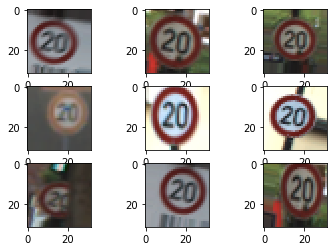

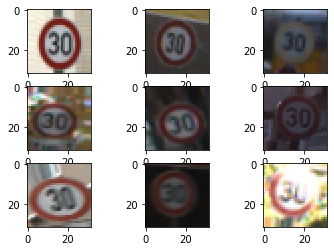

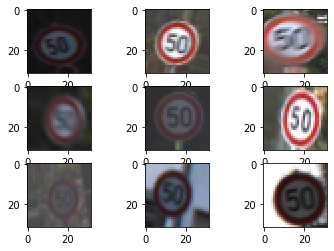

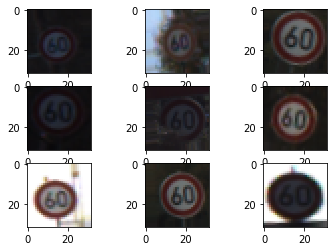

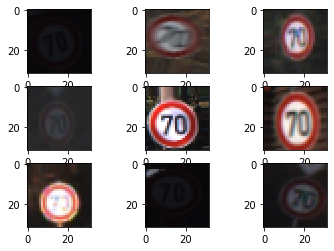

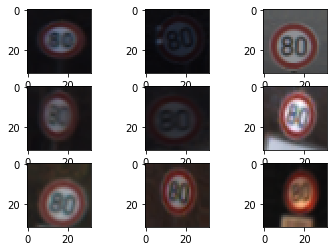

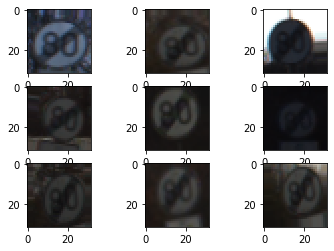

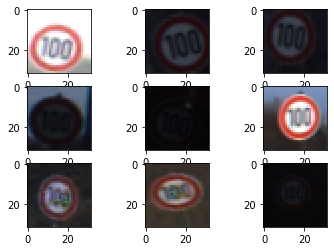

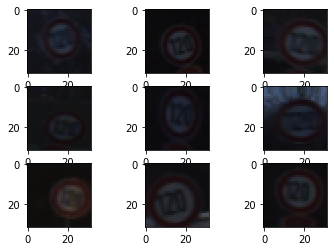

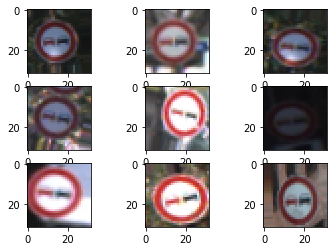

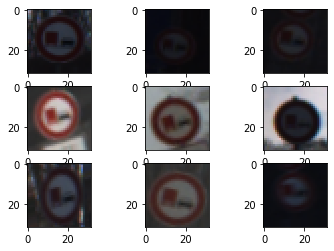

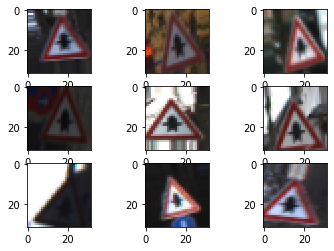

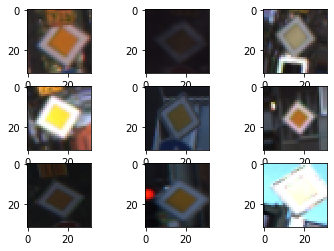

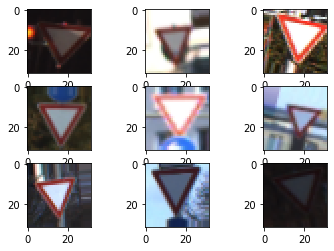

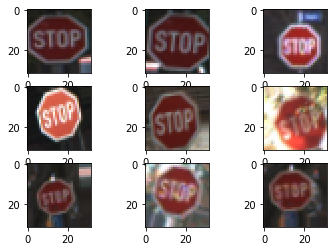

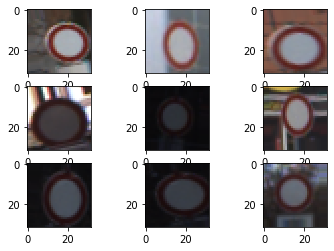

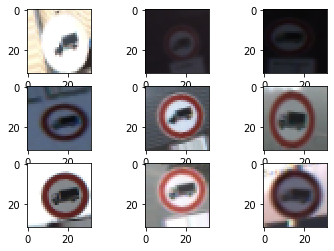

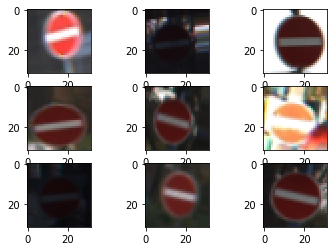

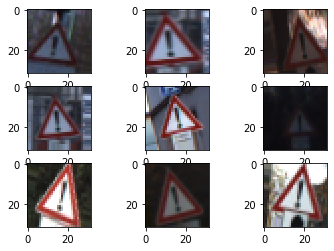

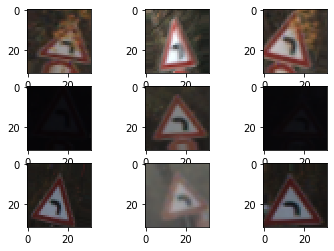

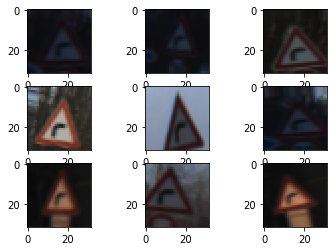

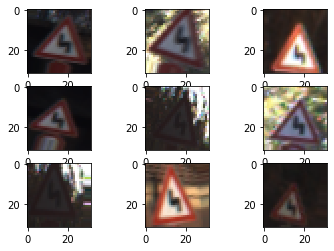

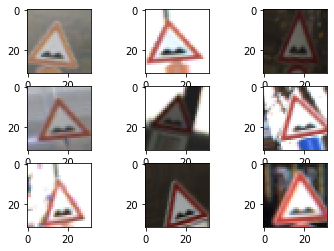

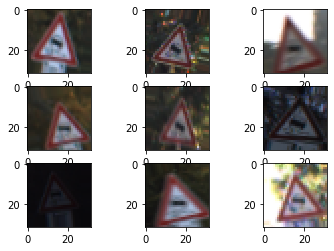

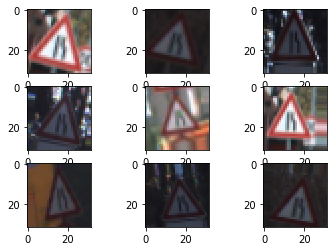

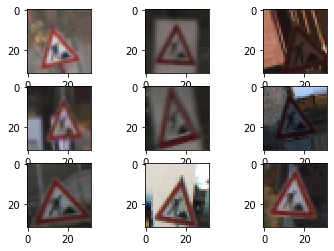

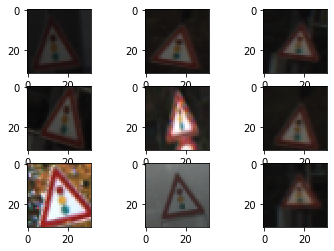

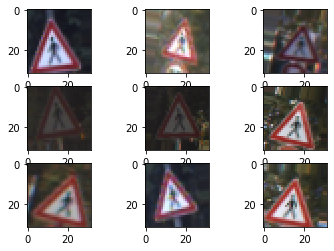

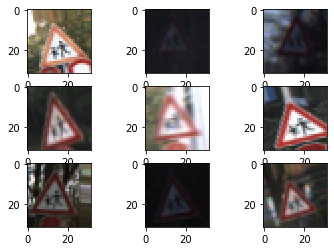

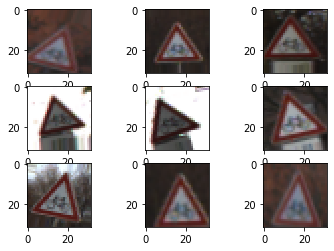

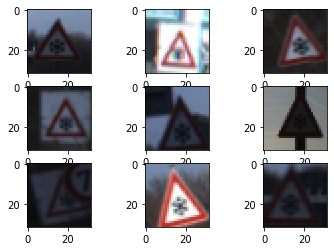

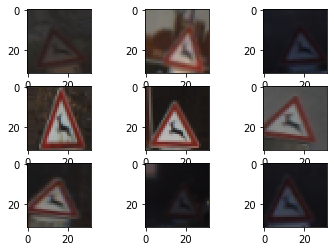

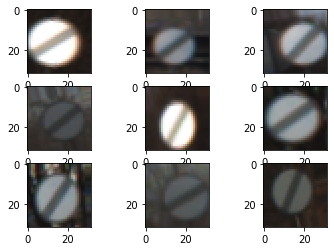

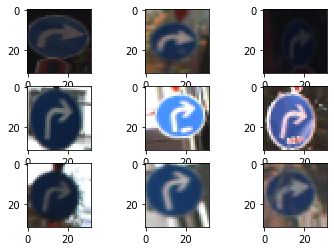

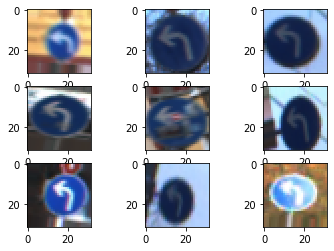

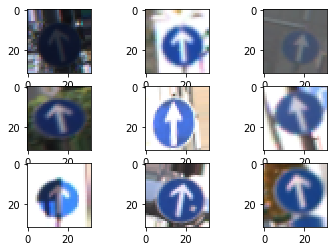

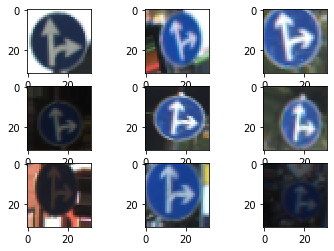

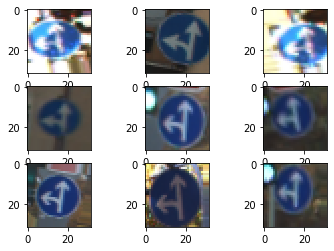

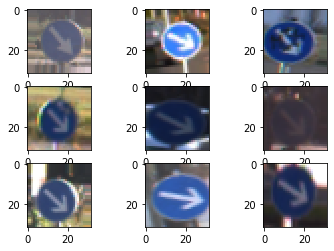

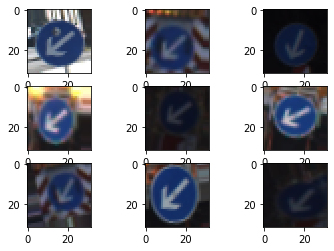

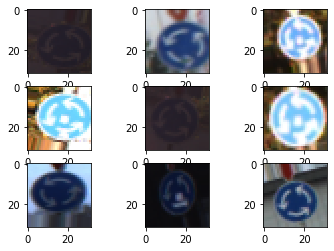

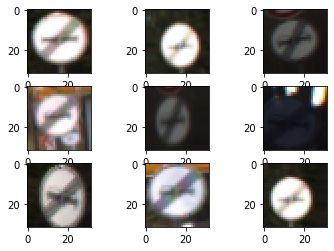

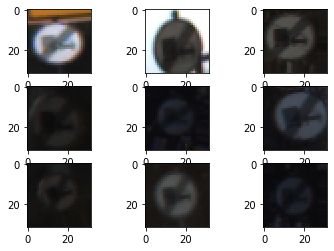

In [96]:
#number of desired images per class
final_img_num = 2500
save_format = '.ppm'
read_format = 'ppm'
#augment images
for c in range(0,43):
    
    X, y = readTrafficSigns(rootpath='GTSRB/Final_Training/Images', IMG_SIZE=32, min_img_size=32, classes=[c], img_format=read_format)

    
    X = X.astype('float32')

    # add arrays to big training array, same for labels
    if c == 0:
        features = X
        labels = np.array(y)
    else:
        features = np.concatenate((features, X), axis=0)
        labels = np.concatenate((labels, y), axis=0)
    datagen.fit(X)
    # save original images
    k = 0
    for img in X:
        cv2.imwrite('New_Augmented_Images/'+'Class'+str(c)+'/orig'+str(k)+save_format,cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        k += 1
    img_num = X.shape[0]
    #augmentation step
    k = 0
    for X_batch, y_batch in datagen.flow(X, y, batch_size=32):#, save_to_dir='New_Augmented_Images/'+'Class'+str(c), save_prefix='aug', save_format='ppm'):
        # check if enough images were generated
        if img_num > final_img_num:
            break
        # create a grid of 3x3 images
        if k == 0:
            for i in range(0, 9):
                plt.subplot(330 + 1 + i)
                plt.imshow(X_batch[i].reshape(X.shape[1], X.shape[2], 3).astype(np.uint8), cmap=plt.get_cmap('gray'))
            # show the plot
            plt.show()
        # save image
        for img in X_batch:
            cv2.imwrite('New_Augmented_Images/'+'Class'+str(c)+'/aug'+str(k)+save_format,cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            k += 1
        img_num += X_batch.shape[0]
        # add to big training array
        features = np.concatenate((features, X_batch), axis=0)
        labels = np.concatenate((labels, y_batch), axis=0)
np.save("aug_features_32x32", features)
np.save("aug_labels_32x32", labels)